In [28]:
from itertools import cycle
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator, AutoLocator
from mpltools import annotation

plt.style.use('seaborn-poster')

/tmp/ipykernel_22325/1257321078.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


In [29]:
!ls conv_rate_results

conv_results_cg_tri		       conv_results_lsh_alternative_quad_new2
conv_results_cgh_quad		       conv_results_lsh_alternative_tri
conv_results_cgh_tri		       conv_results_lsh_embedded_mass_tri
conv_results_cgls_quad		       conv_results_lsh_expanded_quad
conv_results_cgls_tri		       conv_results_lsh_expanded_tri
conv_results_cls_ip_primal_quad        conv_results_lsh_mass_quad
conv_results_clsq_quad		       conv_results_lsh_mass_tri
conv_results_clsq_tri		       conv_results_lsh_quad
conv_results_dls_ip_primal_quad        conv_results_lsh_quad_mesh
conv_results_dls_ip_primal_tri	       conv_results_lsh_quad_new
conv_results_dls_ip_quad	       conv_results_lsh_tri
conv_results_dls_ip_tri		       conv_results_lsh_tri_mesh
conv_results_dls_primal_quad	       conv_results_mixed_RT_quad
conv_results_dls_quad		       conv_results_new_lsh_primal_quad
conv_results_dls_tri		       conv_results_new_lsh_primal_tri
conv_results_hdg_quad		       conv_results_pdglsh_quad
conv_results_hdg_sdhm_tri	

In [30]:
geometry_suffix = "quad"
result_cases_dirname_list = {
    "Mesh-independent": f"conv_results_lsh_{geometry_suffix}",
    "Mesh-dependent": f"conv_results_lsh_{geometry_suffix}_mesh",
    # "LS-h-mass": "conv_results_lsh_embedded_mass_tri",
    # "LS-h-mass": f"conv_results_lsh_mass_{geometry_suffix}",
    # "LS-h-expanded": "conv_results_lsh_expanded_tri",
    # "SDHM": "conv_results_sdhm_quad",
    # "PDLS": f"conv_results_pdls_{geometry_suffix}",
    # "DLS-IP": f"conv_results_dls_ip_{geometry_suffix}",
    # "CLS": "conv_results_cls_ip_primal_quad"
#     "HDG": "conv_results_hdg_tri",
    # "PDLS-h": f"conv_results_pdlsh_{geometry_suffix}",
    # "PDGLS-h": f"conv_results_pdglsh_{geometry_suffix}",
    # "SIPG": f"conv_results_sipg_{geometry_suffix}",
    # "HDG-SDHM": "conv_results_hdg_sdhm_tri",
    # "Interp": f"conv_results_interpolator_primal_{geometry_suffix}",
    # "Interp": "conv_results_interpolator_mixed_quad",
}

In [31]:
all_results = dict()
for case in result_cases_dirname_list:
    dirname = result_cases_dirname_list[case]
    df_result_case = pd.read_csv("./conv_rate_results/%s/errors.csv" % dirname)
    # columns_to_apply = ["H1-error p", "Hdiv-error u", "L2-error p", "L2-error u", "Mesh size"]
    # df_result_case[columns_to_apply] = df_result_case[columns_to_apply].apply(lambda x: np.log2(x))
    all_results[case] = df_result_case
    
# all_results['HDG']

## h-convergence

In [32]:
results_by_degree = dict()
min_degree, max_degree = 1, 4
for degree in range(min_degree, max_degree + 1):
    results_by_case = {}
    for case in result_cases_dirname_list:
        results_by_case[case] = all_results[case][all_results[case]["Degree"] == degree]

    results_by_degree[degree] = results_by_case
    
results_by_degree[1]

{'Mesh-independent':    Unnamed: 0 Element  Degree  Cells  log Cells  Mesh size  Num DOFs  \
 0           0    Quad       1     16    0.60206   0.250000        80   
 1           1    Quad       1     64    0.90309   0.125000       288   
 2           2    Quad       1    256    1.20412   0.062500      1088   
 3           3    Quad       1   1024    1.50515   0.031250      4224   
 4           4    Quad       1   4096    1.80618   0.015625     16640   
 
    log Num DOFs  L2-error p  log L2-error p  ...  H1-error p order  \
 0      1.903090    0.183409       -0.736578  ...          1.023836   
 1      2.459392    0.051894       -1.284879  ...          1.023836   
 2      3.036629    0.013406       -1.872713  ...          1.023836   
 3      3.625724    0.003379       -2.471150  ...          1.023836   
 4      4.221153    0.000847       -3.072297  ...          1.023836   
 
    L2-error u  log L2-error u  L2-error u order  Hdiv-error u  \
 0    1.029665        0.012696           1.981

In [33]:
def plot_convergence_rate_l2(
    results,
    slope_scalar,
    slope_flux,
    slope_marker_idx_to_plot=None,
    ncol=2,
    save_plot=False,
    file_to_save='',
    dir_to_save='',
    figure_extension='png',
    display_plot=True,
    high_quality=False,
    size_frac=0.2,
    figsize=(8, 10)
):
    if high_quality:
            fig, ax = plt.subplots(figsize=figsize, dpi=800)
    else:
        fig, ax = plt.subplots(figsize=figsize)

    cycle_colors = cycle('brgcmk')
    color_scalar = next(cycle_colors)
    color_flux = next(cycle_colors)
    markers = cycle(('s', '*', '^', 'o', 'D', '>', '<')) 
    for case in results:
        # mesh_size = results[case]["log Cells"].values
        mesh_size = -np.log10(results[case]["Mesh size"].values)
        num_dofs_log = results[case]["Num DOFs"].values
        scalar_error = results[case]["log L2-error p"].values
        flux_error = results[case]["log L2-error u"].values
        
        x_axis_values = mesh_size

        marker_scalar = next(markers)
        ax.plot([np.nan], [np.nan], '', color='w', label='%s:' % case)
        ax.plot(
            x_axis_values, 
            scalar_error,
            linestyle="-",
            marker=marker_scalar,
            color=color_scalar,
            markersize=10,
            linewidth=3,
            label=r"$p$"
        )

        marker_flux = next(markers)
        ax.plot(
            x_axis_values, 
            flux_error,
            linestyle="--",
            marker=marker_flux,
            color=color_flux,
            markersize=12,
            linewidth=3,
            label=r"$\nabla p$"
        )
        
    box = ax.get_position()
    # ax.set_position([box.x0, box.y0 + box.height * 0.1,
    #                  box.width, box.height * 0.9])
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
              fancybox=True, shadow=True)
    # ax.legend(loc='center', bbox_to_anchor=(0.5, 1.1),
    #           fancybox=True, shadow=True, ncol=ncol)
    
    plt.xlabel(r"$-\log_{10}( h )$")
    plt.ylabel(r"$\log_{10}\left(||e||_{L^2(\Omega)}\right)$")

    ax.tick_params(which='both', top=True, right=True)
    ax.xaxis.set_major_locator(AutoLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_major_locator(AutoLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=8)
    ax.tick_params(which='minor', length=4)

    id_ref_marker = int(len(scalar_error) / 2)
    if slope_marker_idx_to_plot is not None:
        id_ref_marker = slope_marker_idx_to_plot
    scalar_marker_x = x_axis_values[id_ref_marker] - 0.025 * x_axis_values[id_ref_marker]
    scalar_marker_y = scalar_error[id_ref_marker]
    annotation.slope_marker(
        origin=(scalar_marker_x, scalar_marker_y), 
        slope=-slope_scalar, 
        invert=True, 
        size_frac=size_frac, 
        pad_frac=0.1, 
        text_kwargs={
            'fontsize': 18,
            # 'text': slope_scalar,
            'color': color_scalar
        },
        poly_kwargs={
            'color': color_scalar,
            'alpha': 1
        },
        ax=ax
    )

    flux_marker_x = x_axis_values[id_ref_marker] - 0.025 * x_axis_values[id_ref_marker]
    flux_marker_y = flux_error[id_ref_marker]
    annotation.slope_marker(
        origin=(flux_marker_x, flux_marker_y), 
        slope=-slope_flux, 
        invert=True, 
        size_frac=size_frac, 
        pad_frac=0.1, 
        text_kwargs={
            'fontsize': 18,
            # 'text': slope_flux,
            'color': color_flux
        },
        poly_kwargs={
            'color': color_flux,
            'alpha': 1
        },
        ax=ax
    )

    plt.tight_layout()
    if save_plot:
        if dir_to_save == '':
            dir_to_save = './conv_result'

        os.makedirs(dir_to_save, exist_ok=True)

        if file_to_save == '':
            file_to_save = 'plot_conv_%i' % degree

        file_to_save = f"{dir_to_save}/{file_to_save}" + (".%s" % figure_extension)
        plt.savefig(file_to_save, bbox_inches='tight')

    if display_plot:
        plt.show()
        
    return

In [34]:
def plot_convergence_rate_residual(
    results,
    error_slope,
    slope_case_name=None,
    slope_marker_idx_to_plot=None,
    ncol=2,
    save_plot=False,
    file_to_save='',
    dir_to_save='',
    figure_extension='png',
    display_plot=True,
    high_quality=False,
    size_frac=0.2,
    figsize=(8, 10)
):
    if high_quality:
            fig, ax = plt.subplots(figsize=figsize, dpi=800)
    else:
        fig, ax = plt.subplots(figsize=figsize)

    cycle_colors = cycle('brgcmk')
    color_scalar = next(cycle_colors)
    color_flux = next(cycle_colors)
    markers = cycle(('s', '*', '^', 'o', 'D', '>', '<')) 
    for case in results:
        # mesh_size = results[case]["log Cells"].values
        mesh_size = -np.log10(results[case]["Mesh size"].values)
        num_dofs_log = results[case]["Num DOFs"].values
        error_values = results[case]["log LS-error p"].values
        
        x_axis_values = mesh_size

        marker_scalar = next(markers)
        ax.plot([np.nan], [np.nan], '', color='w', label='%s:' % case)
        ax.plot(
            x_axis_values, 
            error_values,
            linestyle="-",
            marker=marker_scalar,
            color=color_scalar,
            markersize=10,
            linewidth=3,
            label=r"$-\Delta p$ residual"
        )
        if case == slope_case_name:
            id_ref_solution_point_to_marker_default = int(len(error_values) / 2)
            id_ref_marker = id_ref_solution_point_to_marker_default
            if slope_marker_idx_to_plot is not None:
                id_ref_marker = slope_marker_idx_to_plot
            scalar_marker_x = x_axis_values[id_ref_marker] - 0.025 * x_axis_values[id_ref_marker]
            scalar_marker_y = error_values[id_ref_marker]
            annotation.slope_marker(
                origin=(scalar_marker_x, scalar_marker_y), 
                slope=-error_slope, 
                invert=True, 
                size_frac=size_frac, 
                pad_frac=0.1, 
                text_kwargs={
                    'fontsize': 18,
                    # 'text': slope_scalar,
                    'color': color_scalar
                },
                poly_kwargs={
                    'color': color_scalar,
                    'alpha': 1
                },
                ax=ax
            )
                
    if slope_case_name is None:
        id_ref_solution_point_to_marker = int(len(error_values) / 2)
        scalar_marker_x = x_axis_values[id_ref_solution_point_to_marker] - 0.025 * x_axis_values[id_ref_solution_point_to_marker]
        scalar_marker_y = error_values[id_ref_solution_point_to_marker]
        annotation.slope_marker(
            origin=(scalar_marker_x, scalar_marker_y), 
            slope=-error_slope, 
            invert=True, 
            size_frac=size_frac, 
            pad_frac=0.1, 
            text_kwargs={
                'fontsize': 18,
                # 'text': slope_scalar,
                'color': color_scalar
            },
            poly_kwargs={
                'color': color_scalar,
                'alpha': 1
            },
            ax=ax
        )
                
        
    box = ax.get_position()
    # ax.set_position([box.x0, box.y0 + box.height * 0.1,
    #                  box.width, box.height * 0.9])
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
              fancybox=True, shadow=True)
    # ax.legend(loc='center', bbox_to_anchor=(0.5, 1.1),
    #           fancybox=True, shadow=True, ncol=ncol)
    
    plt.xlabel(r"$-\log_{10}( h )$")
    plt.ylabel(r"$\log_{10}\left(||e||_{L^2(\Omega)}\right)$")

    ax.tick_params(which='both', top=True, right=True)
    ax.xaxis.set_major_locator(AutoLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_major_locator(AutoLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=8)
    ax.tick_params(which='minor', length=4)

    plt.tight_layout()
    if save_plot:
        if dir_to_save == '':
            dir_to_save = './conv_result'

        os.makedirs(dir_to_save, exist_ok=True)

        if file_to_save == '':
            file_to_save = 'plot_conv_residual_%i' % degree

        file_to_save = f"{dir_to_save}/{file_to_save}" + (".%s" % figure_extension)
        plt.savefig(file_to_save, bbox_inches='tight')

    if display_plot:
        plt.show()
        
    return

/home/diego/firedrake/lib/python3.9/site-packages/mpltools/annotation/_slopemarker.py:128: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return plt.Polygon(verts, **poly_kwargs)


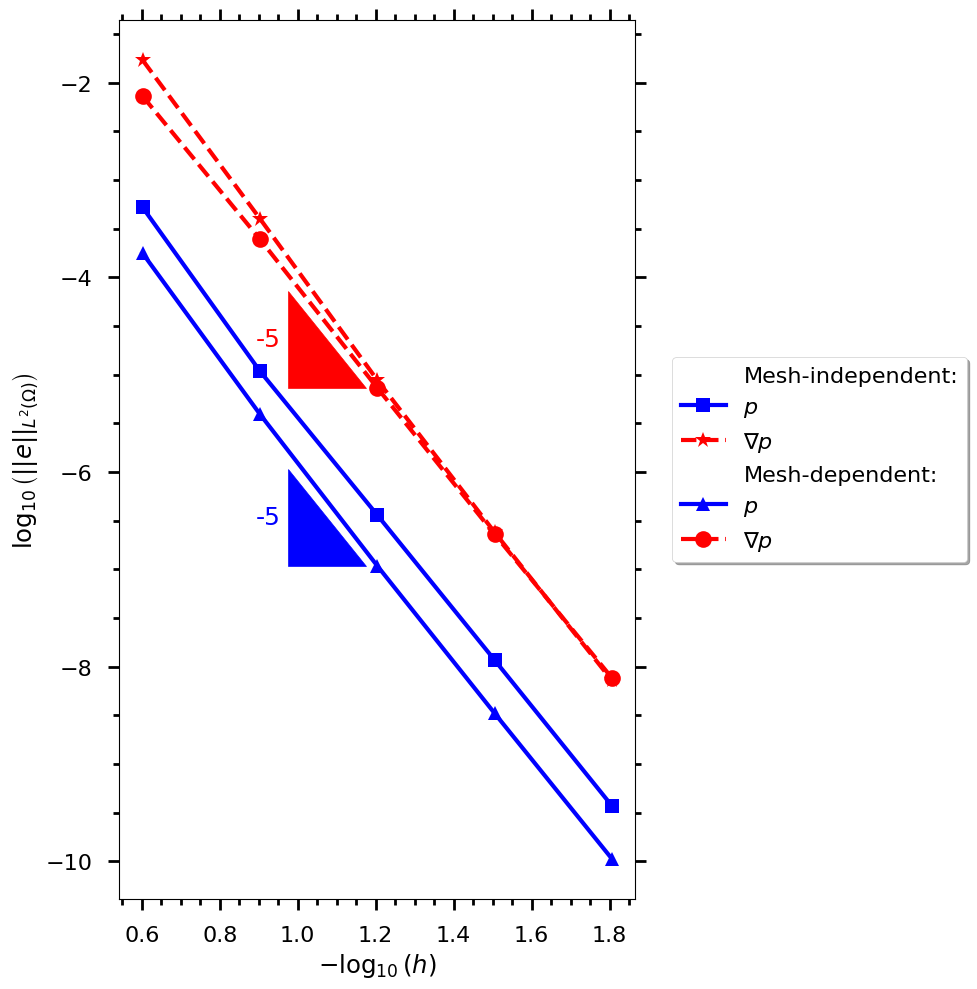

In [35]:
###########################################################
# Tri
###########################################################

# Degree 1
# origin_slope_scalar=(3, -5.),
# origin_slope_flux=(3, -1.5),
# Degree 2
# origin_slope_scalar=(3, -10.5),
# origin_slope_flux=(3, -7.),
# Degree 3
# origin_slope_scalar=(3, -13.75),
# origin_slope_flux=(3, -11.),
# Degree 4
# origin_slope_scalar=(3, -19.),
# origin_slope_flux=(3, -15.5),

###########################################################
# Quads
###########################################################

# Degree 1
# origin_slope_scalar=(3, -4.5),
# origin_slope_flux=(3, -2.5),
# Degree 2
# origin_slope_scalar=(3, -9.5),
# origin_slope_flux=(3, -6.5),
# Degree 3
# origin_slope_scalar=(3, -14.5),
# origin_slope_flux=(3, -8.5),
# Degree 4
# origin_slope_scalar=(3, -19.),
# origin_slope_flux=(3, -12.5),

# filename = 'tri_deg%i' % degree
degree = 4
filename = f'lsh_deg_{degree}_defesa_{geometry_suffix}'
plot_convergence_rate_l2(
    results_by_degree[degree],
    slope_scalar=degree + 1,
    slope_flux=degree + 1,
    ncol=len(results_by_degree[degree]),
    file_to_save=filename,
    size_frac=0.15,
    save_plot=False,
    figsize=(10, 10)
)

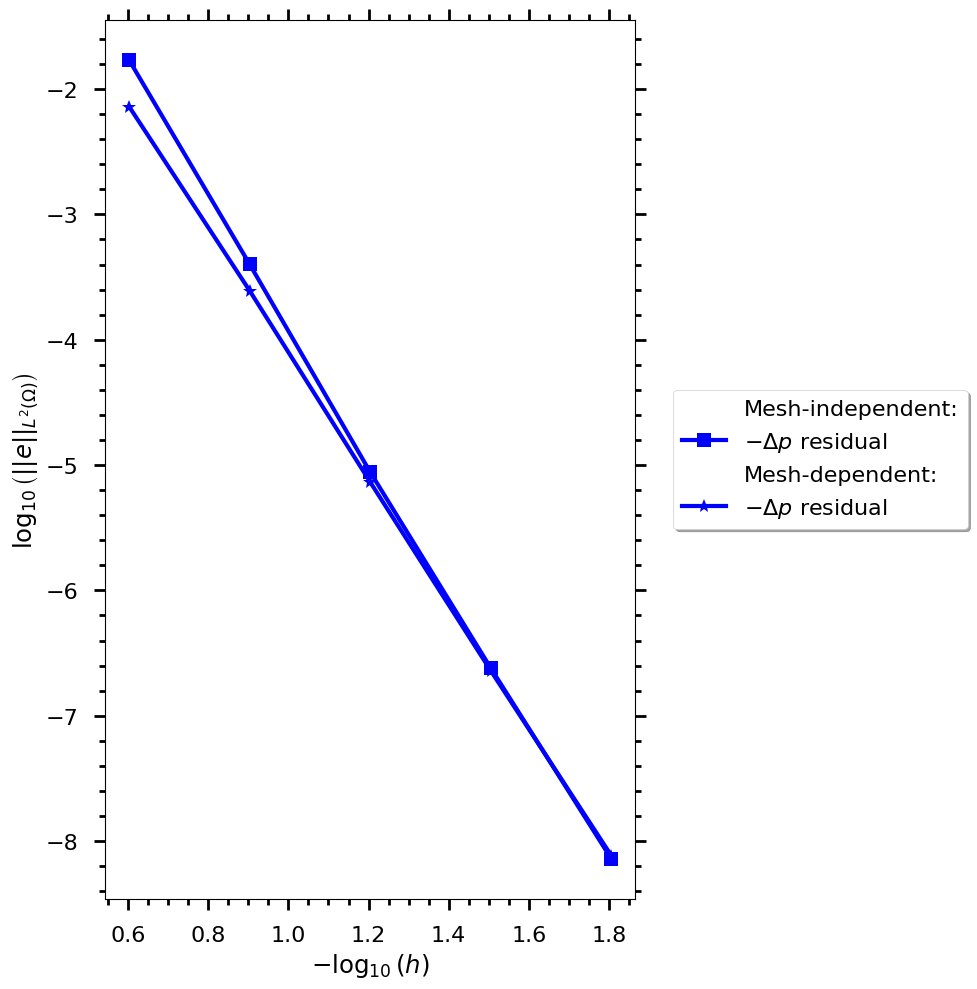

In [36]:
degree = 4
filename = f''
plot_convergence_rate_residual(
    results_by_degree[degree],
    error_slope=degree,
    slope_case_name='PDLS',
    slope_marker_idx_to_plot=-1,
    ncol=len(results_by_degree[degree]),
    file_to_save=filename,
    size_frac=0.15,
    save_plot=False,
    figsize=(10, 10)
)

Saving the errors:

In [37]:
from enum import Enum
from pathlib import Path


class TableFormat(Enum):
    MD = 1
    CSV = 2
    LATEX = 3


# DEFAULT_COLUMNS = [
#     "log Cells", "Degree", "Num DOFs", "log Num DOFs", "log L2-error p", "log L2-error u", "log LS-error p"
# ]
DEFAULT_COLUMNS = [
    "log Mesh size", "Degree", "Num DOFs", "log Num DOFs", "log L2-error p", "log L2-error u", "log LS-error p"
]

def export_error_table_by_degree(
    df_results_by_degree,
    table_format=TableFormat.CSV,
    columns=DEFAULT_COLUMNS,
    dir_to_save='',
    filename=''
):
    if dir_to_save == '':
        dir_to_save = './conv_result'

    os.makedirs(dir_to_save, exist_ok=True)
    
    if filename == '':
        filename = f'table_errors'

    file_to_save_full = Path(f"{dir_to_save}/{filename}")
    
    df_case = df_results_by_degree
    log_mesh_size = -np.log10(df_case["Mesh size"].values)
    
    degree = df_case["Degree"].values[0]
    columns_to_save = columns
    df_case["log Mesh size"] = log_mesh_size
    df_case = df_case[columns_to_save]
    df_case.reset_index(inplace=True, drop=True)

    if table_format is TableFormat.CSV:
        file_to_save_full = f"{file_to_save_full}_deg{degree}.csv"
        df_case.to_csv(file_to_save_full)

    elif table_format is TableFormat.MD:
        file_to_save_full = f"{file_to_save_full}_deg{degree}.md"
        df_case.to_markdown(file_to_save_full)
        
    elif table_format is TableFormat.LATEX:
        file_to_save_full = f"{file_to_save_full}_deg{degree}.tex"
        df_case.to_latex(file_to_save_full, index=False)
        
    return

In [38]:
columns_to_tex = [
    "log Mesh size", "Num DOFs", "log L2-error p", "log L2-error u", "log LS-error p"
]
for degree in results_by_degree:
    results_degree = results_by_degree[degree]
    for method in results_degree:
        export_error_table_by_degree(
            results_degree[method], 
            table_format=TableFormat.MD,
            filename=f"error_table_{method}_{geometry_suffix}"
        )
        
        export_error_table_by_degree(
            results_degree[method], 
            table_format=TableFormat.CSV,
            filename=f"error_table_{method}_{geometry_suffix}"
        )
        
        export_error_table_by_degree(
            results_degree[method], 
            table_format=TableFormat.LATEX,
            filename=f"error_table_{method}_{geometry_suffix}",
            columns=columns_to_tex
        )

/tmp/ipykernel_22325/70229365.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_case["log Mesh size"] = log_mesh_size
/tmp/ipykernel_22325/70229365.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_case["log Mesh size"] = log_mesh_size
/tmp/ipykernel_22325/70229365.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

Saving the plots:

/home/diego/firedrake/lib/python3.9/site-packages/mpltools/annotation/_slopemarker.py:128: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return plt.Polygon(verts, **poly_kwargs)


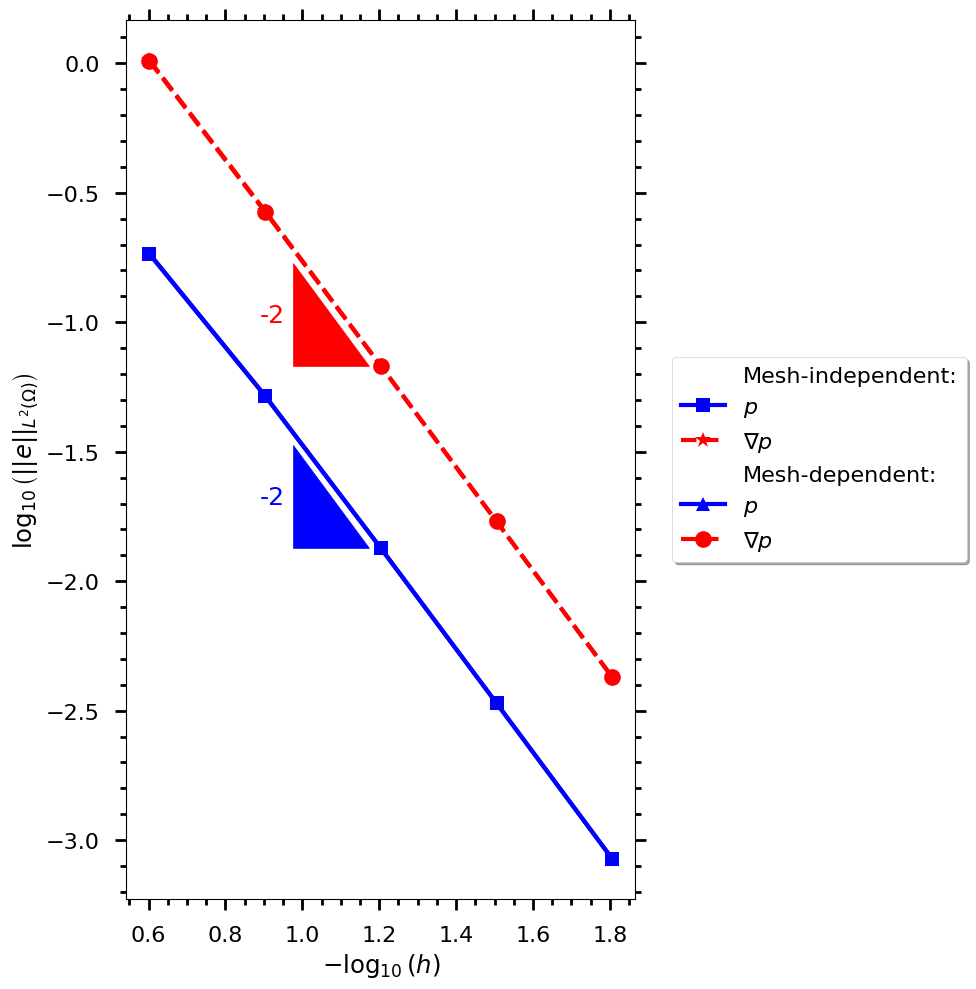

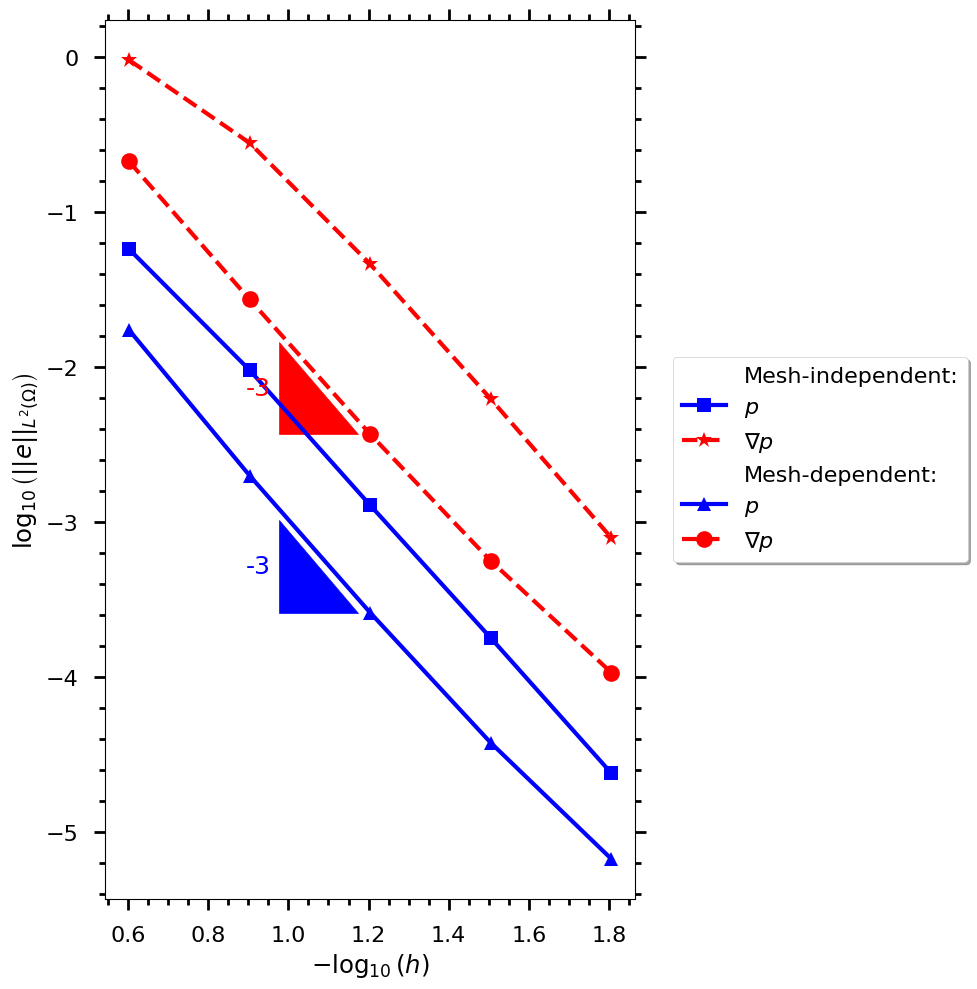

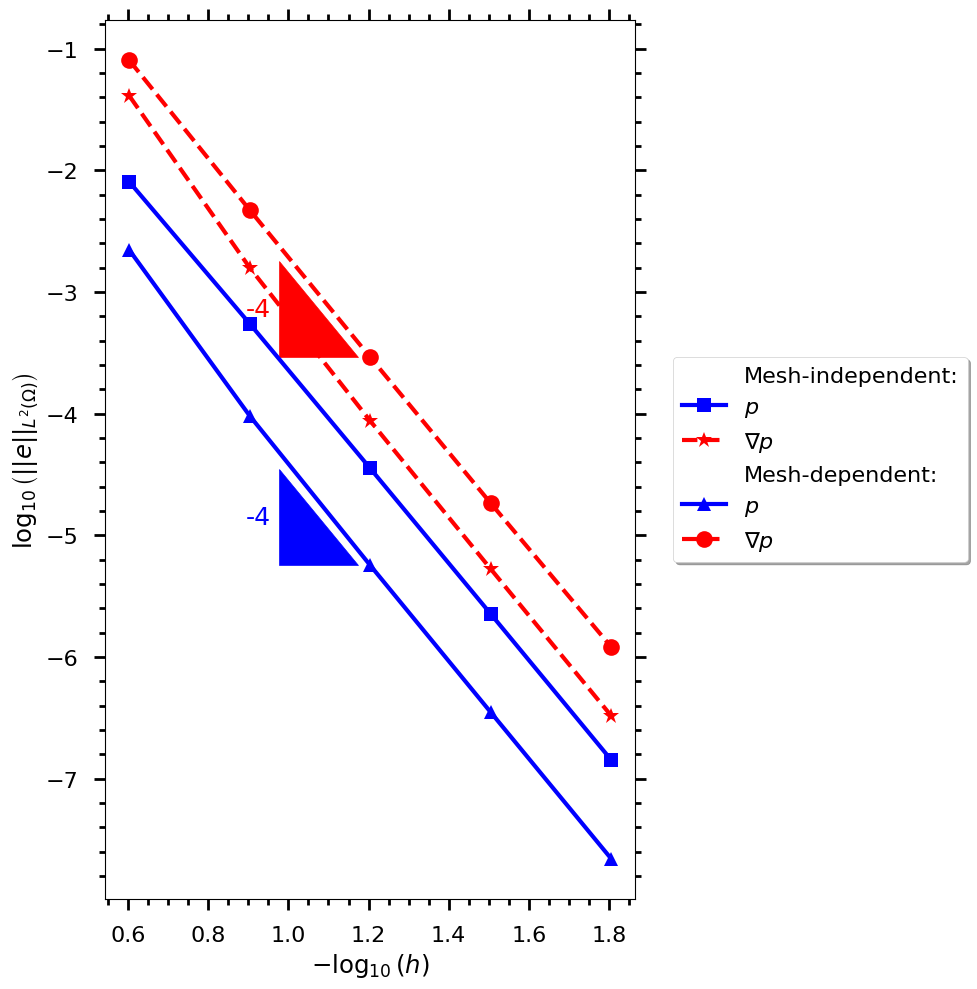

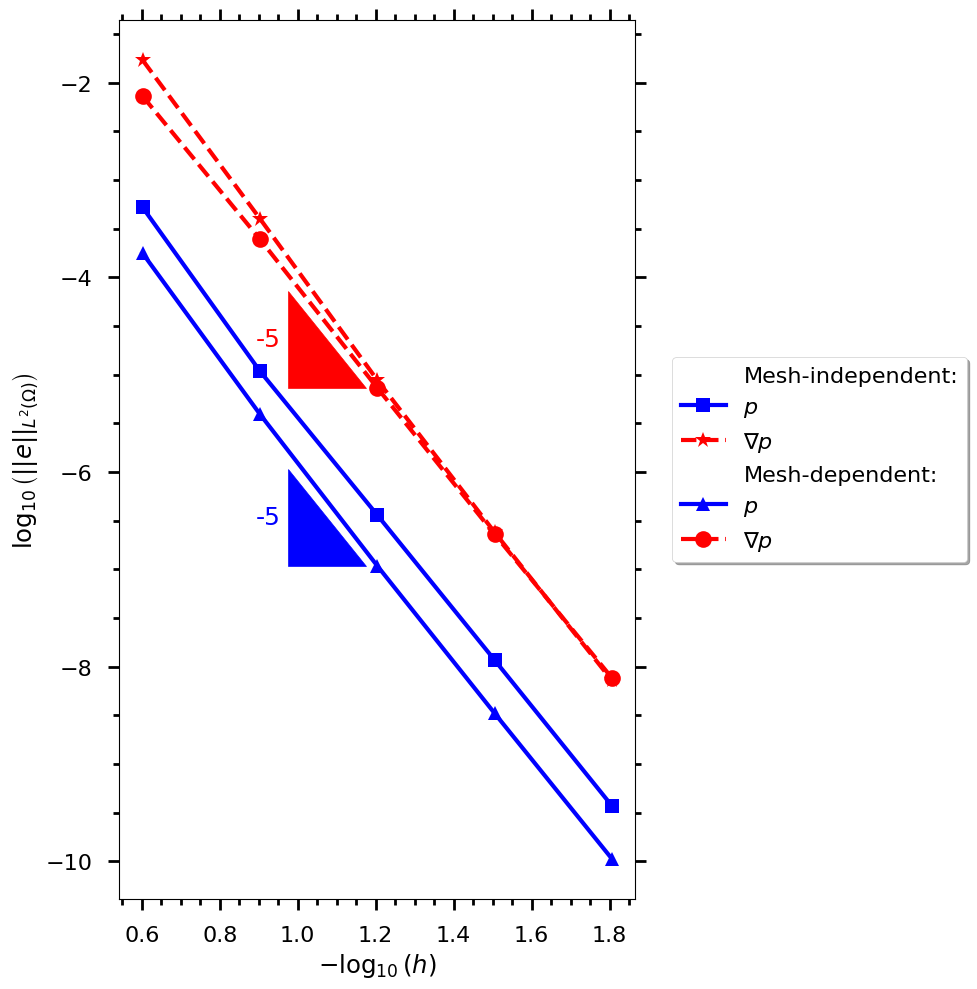

In [39]:
for degree in list(results_by_degree.keys()):
    filename = f'mixed_lsh_deg_{degree}_defesa_{geometry_suffix}'
    slope_p = degree + 1
    id_rate_marker = -3
    # if geometry_suffix == 'tri':
    #     # slope_p = degree + 1 if degree != 2 else degree
    #     if degree == 2:
    #         pass
    #         slope_p = degree
            
    # if geometry_suffix == 'quad':
    #     # slope_p = degree + 1 if degree != 2 else degree
    #     if degree == 3:
    #         id_rate_marker = -1
            
    #     if degree == 4:
    #         id_rate_marker = -1

    # slope_p = degree + 1
    plot_convergence_rate_l2(
        results_by_degree[degree],
        slope_scalar=slope_p,
        slope_flux=slope_p,
        slope_marker_idx_to_plot=id_rate_marker,
        ncol=len(results_by_degree[degree]),
        file_to_save=filename,
        size_frac=0.15,
        save_plot=True,
        figsize=(10, 10),
    )

In [40]:
PLOT_RESIDUAL = False
if PLOT_RESIDUAL:
    for degree in list(results_by_degree.keys())[1:]:
        filename = f'pdlsh_residual_{geometry_suffix}_{degree}_seminario'
        slope_p = degree - 1
        if geometry_suffix == 'quad':
            slope_p = degree
            # slope_p = degree if degree % 2 != 0 else degree - 1
            
        # slope_p = slope_p if degree != 3 else degree + 1
        plot_convergence_rate_residual(
            results_by_degree[degree],
            error_slope=slope_p,
            slope_case_name="PDLS",
            slope_marker_idx_to_plot=-1,
            ncol=len(results_by_degree[degree]),
            file_to_save=filename,
            size_frac=0.15,
            save_plot=False,
            figsize=(8, 10),
        )

## p-convergence